# Discovering chemicals in patents by assessing their findability
 Prevalent sections in patent documents capturing compound information

# Import Modules

In [1]:
import os
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()

# Add path constants

In [2]:
FIG_DIR = "../data/figures"
DATA_DIR = "../data/raw"
PROCESSED_DIR = "../data/processed"
os.makedirs(FIG_DIR, exist_ok=True)

# Load data file

In [3]:
surechembl_df = pd.read_parquet(f"{DATA_DIR}/surechembl_dump.pq")
surechembl_df.head(2)

,SureChEMBL_ID,SMILES,InChIKey,PATENT_ID,PUBLICATION_DATE,Field
0,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2842582-A2,2015-03-04,Description
1,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2838373-A2,2015-02-25,Description


# Filtering unique compounds per year

In [4]:
surechembl_df["year"] = surechembl_df["PUBLICATION_DATE"].progress_apply(
    lambda x: x.split("-")[0]
)

100%|██████████| 133512452/133512452 [00:50<00:00, 2659582.84it/s]


In [5]:
surechembl_df["country"] = surechembl_df["PATENT_ID"].progress_map(
    lambda x: x.split("-")[0]
)

100%|██████████| 133512452/133512452 [00:55<00:00, 2394395.13it/s]


# Averge annotations per compound and patents

In [6]:
patent_source_cmpd_dict = defaultdict(lambda: defaultdict(int))

for inchikey, field in tqdm(surechembl_df[["InChIKey", "Field"]].values):
    patent_source_cmpd_dict[inchikey][field] += 1

100%|██████████| 133512452/133512452 [01:11<00:00, 1867119.53it/s]


In [7]:
compounds_with_multiple_annotations = [
    k for k, v in patent_source_cmpd_dict.items() if len(v) > 1
]

# Average of the number of annotations per compound
(len(compounds_with_multiple_annotations) / len(patent_source_cmpd_dict)) * 100

31.26714741178417

In [8]:
patent_source_pat_dict = defaultdict(lambda: defaultdict(int))

for inchikey, field in tqdm(surechembl_df[["PATENT_ID", "Field"]].values):
    patent_source_pat_dict[inchikey][field] += 1

100%|██████████| 133512452/133512452 [01:14<00:00, 1784019.69it/s]


In [9]:
patents_with_multiple_annotations = [
    k for k, v in patent_source_pat_dict.items() if len(v) > 1
]

# Average of the number of annotations per patent
(len(patents_with_multiple_annotations) / len(patent_source_pat_dict)) * 100

53.6823908517835

In [10]:
country_field_dict = defaultdict(set)

for country, field_name in tqdm(surechembl_df[["country", "Field"]].values):
    country_field_dict[country].add(field_name)

country_field_dict

100%|██████████| 133512452/133512452 [00:56<00:00, 2358828.28it/s]


defaultdict(set,
            {'EP': {'Abstract',
              'Claims',
              'Description',
              'Image (for patents after 2007)',
              'Title'},
             'US': {'Abstract',
              'Claims',
              'Description',
              'Image (for patents after 2007)',
              'MOL Attachment (US patents after 2007)',
              'Title'},
             'WO': {'Abstract',
              'Claims',
              'Description',
              'Image (for patents after 2007)',
              'Title'},
             'JP': {'Abstract', 'Title'}})

# Calculate Fields for unique compounds per year

In [11]:
patent_field_dict = defaultdict(set)

for inchikey, field in tqdm(surechembl_df[["InChIKey", "Field"]].values):
    patent_field_dict[field].add(inchikey)

patent_field_dict = {i: len(j) for i, j in patent_field_dict.items()}

len(patent_field_dict)

100%|██████████| 133512452/133512452 [00:58<00:00, 2277955.06it/s]


6

In [12]:
field_count_df = pd.DataFrame([patent_field_dict]).T.reset_index()
field_count_df.columns = ["field", "count"]

In [13]:
rename_vals = {
    "Image (for patents after 2007)": "Image",
    "MOL Attachment (US patents after 2007)": "MOL file",
}
field_count_df["field"] = field_count_df["field"].progress_map(
    lambda x: rename_vals[x] if x in rename_vals else x
)
field_count_df.sort_values("count", ascending=False, inplace=True)
field_count_df

100%|██████████| 6/6 [00:00<00:00, 24990.89it/s]


,field,count
2,Image,7394262
0,Description,4319877
4,MOL file,2303403
1,Claims,1325618
3,Abstract,31316
5,Title,11196


# Normalizing counts in percentages

In [14]:
total_count = field_count_df["count"].sum()
field_count_df["percentage"] = field_count_df["count"].progress_map(
    lambda x: (x / total_count) * 100
)

100%|██████████| 6/6 [00:00<00:00, 40265.32it/s]


In [15]:
patent_proportion_df = surechembl_df["Field"].value_counts(normalize=True).reset_index()
patent_proportion_df["proportion"] = patent_proportion_df["proportion"] * 100
patent_proportion_df["Field"] = patent_proportion_df["Field"].map(
    lambda x: rename_vals[x] if x in rename_vals else x
)
patent_proportion_df.sort_values("proportion", ascending=False, inplace=True)

# Visualisation

In [16]:
sns.set_style("whitegrid")

In [17]:
custom_palette = {
    "Image": "#ffbe7d",
    "Description": "#7dbeff",
    "MOL file": "#ffbe7d",
    "Claims": "#7dbeff",
    "Abstract": "#7dbeff",
    "Title": "#7dbeff",
}

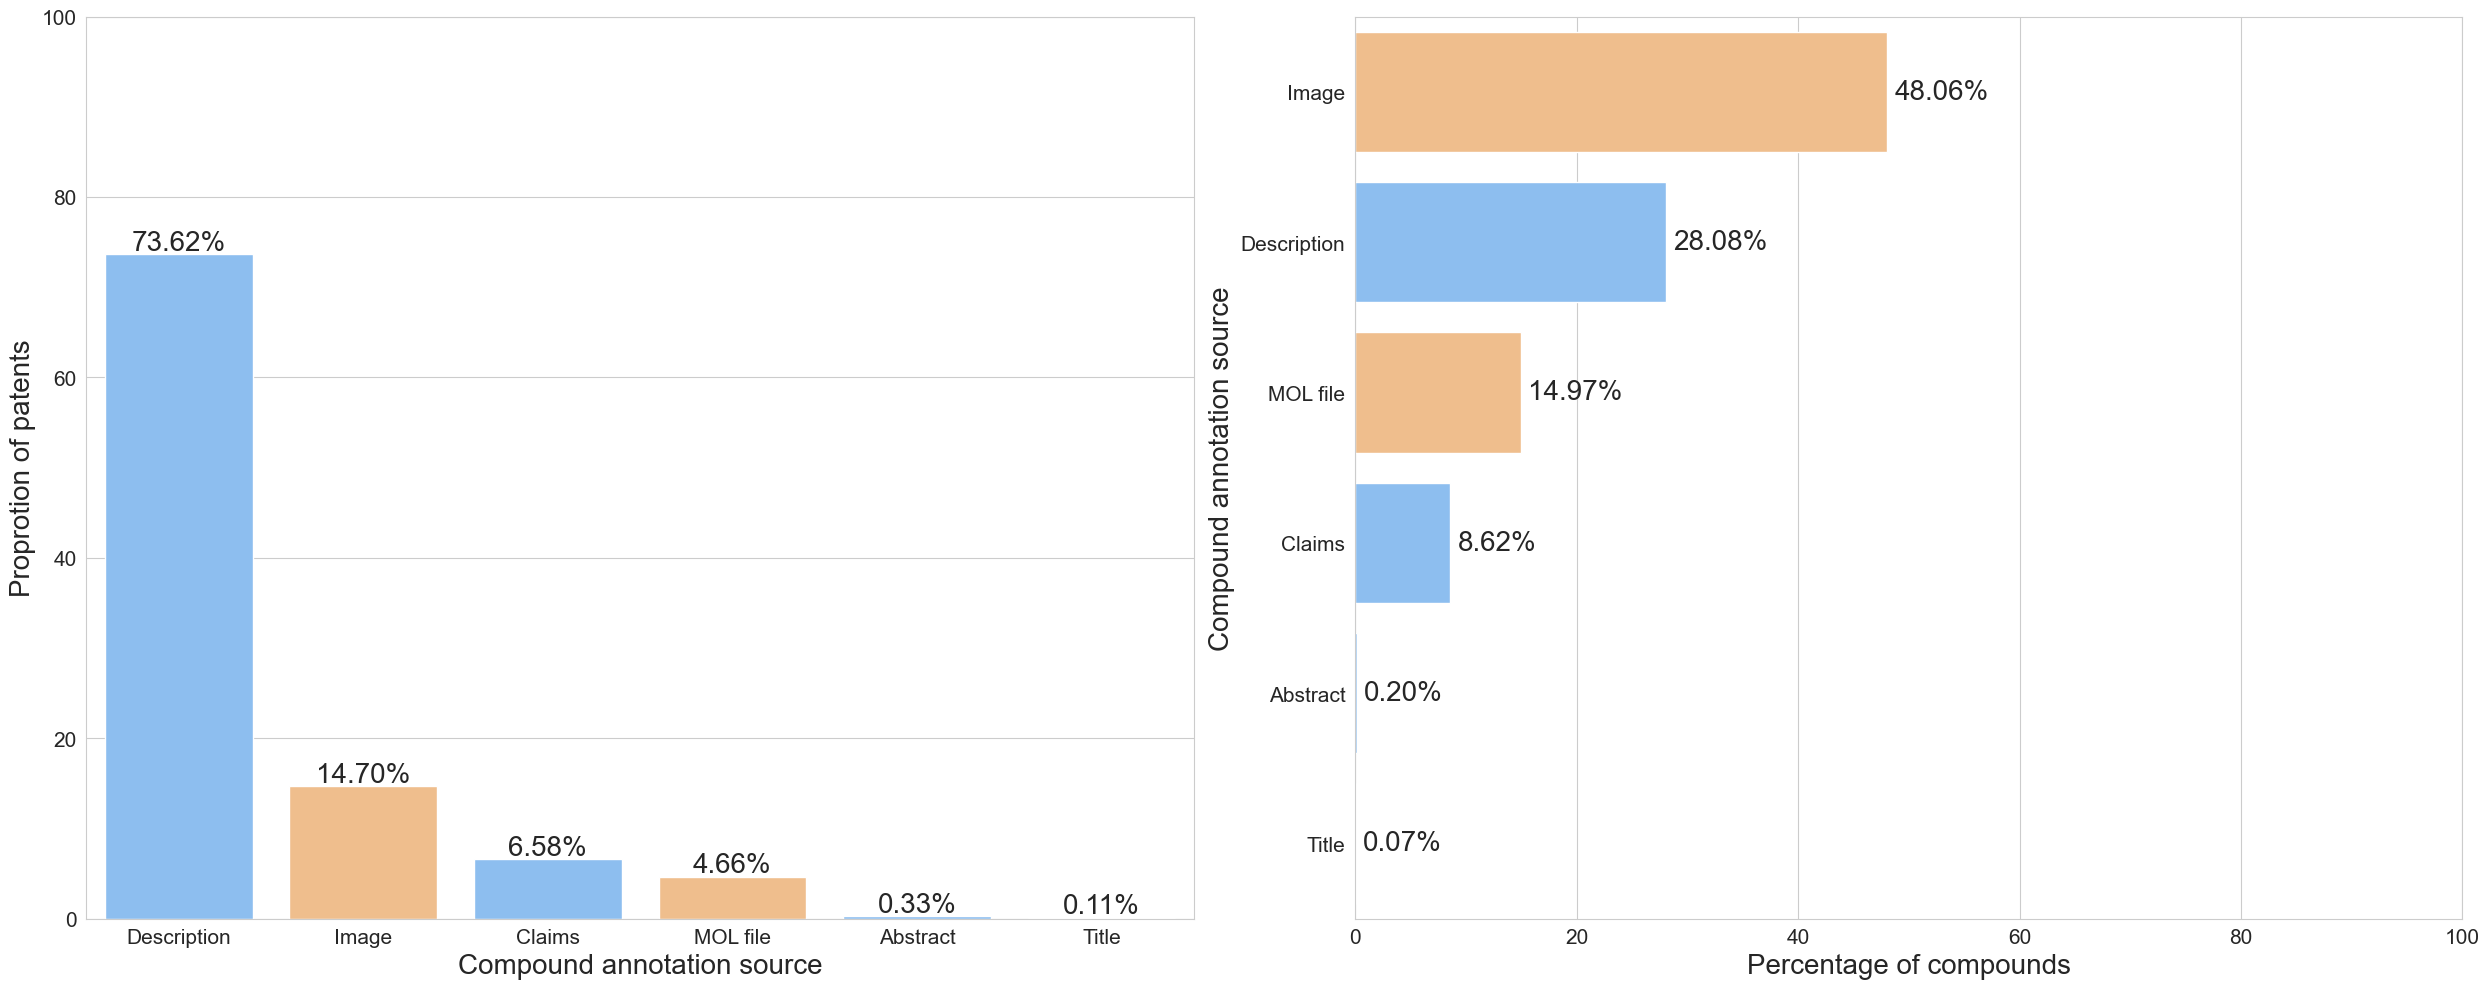

In [18]:
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
ax = sns.barplot(
    data=patent_proportion_df,
    x="Field",
    y="proportion",
    palette=[custom_palette[i] for i in patent_proportion_df["Field"].values],
    hue="Field",
    legend=False,
)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Compound annotation source", fontsize=20)
plt.ylabel("Proprotion of patents", fontsize=20)
plt.ylim(0, 100)

for p in ax.patches:
    t = p.get_height()
    ax.annotate(
        "%.2f" % t + "%",
        xy=(p.get_x() + p.get_width() / 2, p.get_height()),
        xytext=(0, 8),
        textcoords="offset points",
        ha="center",
        va="center",
        fontsize=20,
    )

plt.subplot(1, 2, 2)
ax2 = sns.barplot(
    data=field_count_df,
    x="percentage",
    y="field",
    orient="h",
    palette=[custom_palette[i] for i in field_count_df["field"].values],
    hue="field",
    legend=False,
)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Percentage of compounds", fontsize=20)
plt.ylabel("Compound annotation source", fontsize=20)
plt.xlim(0, 100)

for p in ax2.patches:
    t = p.get_width()
    ax2.annotate(
        "%.2f" % t + "%",
        xy=(p.get_width(), p.get_y() + p.get_height() / 2),
        xytext=(5, 0),
        textcoords="offset points",
        ha="left",
        va="center",
        fontsize=20,
    )
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure_3.png", dpi=400)
plt.show()